In [1]:
import math
import heapq
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import random
import unittest
import collections
from scipy.spatial import cKDTree
import time
import psutil
import os

In [2]:
# Used for sizes of graphs used for runtime/memory usage
node_sizes = [25, 50, 75, 100, 150, 200, 250, 300]

In [3]:
# Written by Emily
def get_memory_usage():
  process = psutil.Process(os.getpid())
  # return the bytes
  return process.memory_info().rss

In [4]:
# CHATGPT skeleton, took a lot of debugging to actually get working
def aux_path_search(G, source, target, removed, via_cost):
    heap = [(0, source)]
    distances = {source: 0}
    
    while heap:
        cost, node = heapq.heappop(heap)
        if cost >= via_cost:
            return math.inf
        if node == target:
            return cost
        for neighbor in G.neighbors(node):
            if neighbor == removed:
                continue
            edge_weight = G[node][neighbor].get('weight', 1)
            new_cost = cost + edge_weight
            if new_cost < distances.get(neighbor, math.inf):
                distances[neighbor] = new_cost
                heapq.heappush(heap, (new_cost, neighbor))

    return math.inf

In [5]:
def compute_edge_diff(G, v):
    neighbors = list(G.neighbors(v))
    shortcuts_added = 0
    for u, w in combinations(neighbors, 2):
        cost_uv = G[u][v].get('weight') if G.has_edge(u, v) else math.inf
        cost_vw = G[v][w].get('weight') if G.has_edge(v, w) else math.inf
        if cost_uv == None or cost_vw == None:
            continue
        via_cost = cost_uv + cost_vw
        aux_path_cost = aux_path_search(G, u, w, v, via_cost)
        if aux_path_cost > via_cost:
            shortcuts_added += 1
    edges_removed = len(neighbors)
    return shortcuts_added - edges_removed, shortcuts_added

In [6]:
def contract_node(G_work, v, current_rank, shortcuts, rank_dict, aux_g):
    neighbors = list(G_work.neighbors(v))
    for u, w in combinations(neighbors, 2):
        if not (G_work.has_edge(u, v) and G_work.has_edge(v, w)):
            continue

        cost_uv = G_work[u][v]['weight']
        cost_vw = G_work[v][w]['weight']
        via_cost = cost_uv + cost_vw
        aux_path_cost = aux_path_search(G_work, u, w, v, via_cost)
        if aux_path_cost > via_cost:  # Shortcut is needed
            if (u, w) in shortcuts and shortcuts[(u, w)]['weight'] > via_cost:
                aux_g[u][w].update({'weight': via_cost, 'via': v})
                G_work[u][w].update({'weight': via_cost, 'via': v})
                shortcuts[(u, w)]['weight'] = via_cost
                shortcuts[(u, w)]['via'].append(v)
            else:
                shortcuts[(u, w)] = {'weight': via_cost, 'via': [v]}
                aux_g.add_edge(u, w, weight=via_cost, shortcut=True, via=v)
                G_work.add_edge(u, w, weight=via_cost, shortcut=True, via=v)

    rank_dict[v] = current_rank
    G_work.remove_node(v)

In [7]:
def build_contraction_hierarchy_offline(G):
    start_time = time.time()
    G_work = G.copy()
    G_aux = G.copy()
    shortcuts = {}
    rank_dict = {}

    edge_diffs = {
        v: (compute_edge_diff(G, v)[0], G.degree(v))  # (shortcut_count, degree)
        for v in G.nodes()
    }
    order = sorted(edge_diffs, key=lambda v: (edge_diffs[v][0], edge_diffs[v][1]))
    current_rank = 0
    for v in order:
        contract_node(G_work, v, current_rank, shortcuts, rank_dict, G_aux)
        current_rank += 1
    end_time = time.time()
    
    return G_aux, rank_dict, order, shortcuts, (end_time - start_time)

In [8]:
def build_contraction_hierarchy_online(G):
    start_time = time.time()
    G_work = G.copy()
    G_aux = G.copy()
    shortcuts = {}
    rank_dict = {}
    current_rank = 0
    process_order = []

    edge_diffs = {v: (compute_edge_diff(G_work, v)[0], G_work.degree(v)) for v in G_work.nodes()}

    while G_work.nodes():
        # Select the node with the smallest edge difference. Tie-break by node degree.
        v_min = min(edge_diffs, key=lambda v: (edge_diffs[v][0], edge_diffs[v][1]))

        v_neighbors = list(G_work.neighbors(v_min))
        edge_diffs.pop(v_min)

        process_order.append(v_min)
        contract_node(G_work, v_min, current_rank, shortcuts, rank_dict, G_aux)
        current_rank += 1

        # update edge difference dict
        for node in v_neighbors:
            if node in edge_diffs:
                edge_diffs[node] = compute_edge_diff(G_work, node)[0], G_work.degree(node)
    end_time = time.time()
    
    return G_aux, rank_dict, process_order, shortcuts, (end_time - start_time)

In [9]:
# CHATGPT skeleton, took tons of debugging to actually work
def bi_dijkstras_ch(aux_g, rank, source, target):
    start_time = time.time()
    forward_heap = [(0, source)]
    reverse_heap = [(0, target)]

    forward_dist = {source: 0}
    reverse_dist = {target: 0}
    processed_forward = set()
    processed_reverse = set()

    best_path = math.inf
    meeting_point = None

    while forward_heap or reverse_heap:
        # ------ Forward Search ------
        if len(forward_heap) != 0:
            cost_f, node_f = heapq.heappop(forward_heap)
            if node_f in processed_forward:
                continue
            processed_forward.add(node_f)

            for neighbor in aux_g.neighbors(node_f):
                if rank[node_f] > rank[neighbor]:
                    continue

                weight = aux_g[node_f][neighbor]['weight']
                new_cost = cost_f + weight

                if new_cost < forward_dist.get(neighbor, math.inf):
                    forward_dist[neighbor] = new_cost
                    heapq.heappush(forward_heap, (new_cost, neighbor))

        # ------ Reverse Search ------
        if len(reverse_heap) != 0:
            cost_r, node_r = heapq.heappop(reverse_heap)
            if node_r in processed_reverse:
                continue
            processed_reverse.add(node_r)

            for neighbor in aux_g.neighbors(node_r):
                if rank[node_r] > rank[neighbor]:
                    continue

                weight = aux_g[node_r][neighbor]['weight']
                new_cost = cost_r + weight

                if new_cost < reverse_dist.get(neighbor, math.inf):
                    reverse_dist[neighbor] = new_cost
                    heapq.heappush(reverse_heap, (new_cost, neighbor))

        # Check for Overlap
        common_nodes = processed_forward & processed_reverse
        for node in common_nodes:
            path_cost = forward_dist[node] + reverse_dist[node]
            if path_cost < best_path:
                best_path = path_cost
                meeting_point = node
    end_time = time.time()

    return best_path, meeting_point, (end_time - start_time)

In [10]:
# Written by Emily
def generate_low_doubling_and_highway_graph(n, dim=2, radius=0.2):
    # generate n random points in a dim-dimensional space
    points = np.random.rand(n, dim)

    # create a k-d tree for efficient nearest neighbor search
    tree = cKDTree(points)

    # find all pairs within the radius
    edges = tree.query_pairs(radius)

    # fill the graph
    G = nx.Graph()
    for i in range(n):
        G.add_node(i, pos=points[i])

    # Get the position dictionary
    pos = nx.get_node_attributes(G, 'pos')  # Get the position dictionary

    for u, v in edges:
        G.add_edge(u, v)
        dist = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))
        G[u][v]['weight'] = dist

    return G, points

def generate_low_doubling_dimension_graph(n, dim=2, radius=0.2):
  G = nx.random_geometric_graph(n, radius)

  # Get the position dictionary
  pos = nx.get_node_attributes(G, 'pos')

  # Add weights based on Euclidean distances
  for (u, v) in G.edges():
      dist = np.linalg.norm(np.array(pos[u]) - np.array(pos[v]))
      G[u][v]['weight'] = dist

  return G, pos

In [11]:
# CHATGPT
def pick_distant_nodes(G):
    source = random.choice(list(G.nodes))  # Pick a random source
    shortest_paths = nx.single_source_dijkstra_path_length(G, source, weight="weight")  # Compute shortest paths
    target = max(shortest_paths, key=shortest_paths.get)  # Pick the farthest node
    
    return source, target

In [12]:
class TestCHDijkstra(unittest.TestCase):
    max_iters = 100
    tolerance = 1.05 # some small graphs return float path length, if within 5% of cost call them euqal

    def test_offline(self):
        for _ in range(self.max_iters):
            G, _ = generate_low_doubling_and_highway_graph(n=100)

            source, target = pick_distant_nodes(G)

            try:
                control_sp = nx.shortest_path_length(G, source=source, target=target, weight='weight')
            except nx.exception.NetworkXNoPath:
                print("NOPATH")

            aux_g_offline, rank_offline, process_order_offline, shortcuts_offline, _ = build_contraction_hierarchy_offline(G)
            best_path, _, _ = bi_dijkstras_ch(aux_g_offline, rank_offline, source, target)

            lower_bound = control_sp / self.tolerance
            upper_bound = control_sp * self.tolerance

            self.assertTrue(lower_bound <= best_path <= upper_bound,
                            f"Path cost {best_path} outside range ({lower_bound}, {upper_bound}) for control {control_sp}")

    def test_online(self):
        for _ in range(self.max_iters):
            G, _ = generate_low_doubling_and_highway_graph(n=100)
            source, target = pick_distant_nodes(G)

            try:
                 control_sp = nx.shortest_path_length(G, source=source, target=target, weight='weight')
            except nx.exception.NetworkXNoPath:
                print("NOPATH")
                
            aux_g_online, rank_online, process_order_online, shortcuts_online, _ = build_contraction_hierarchy_online(G)
            best_path, _ , _= bi_dijkstras_ch(aux_g_online, rank_online, source, target)

            lower_bound = control_sp / self.tolerance
            upper_bound = control_sp * self.tolerance

            self.assertTrue(lower_bound <= best_path <= upper_bound,
                            f"Path cost {best_path} outside range ({lower_bound}, {upper_bound}) for control {control_sp}")

In [13]:
unittest.TextTestRunner().run(unittest.defaultTestLoader.loadTestsFromTestCase(TestCHDijkstra))

..
----------------------------------------------------------------------
Ran 2 tests in 154.860s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [14]:
# Written by Emily
def estimate_doubling_constant(G, num_samples=10, r_fraction=0.1):
    nodes = list(G.nodes)
    shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    # compute approximate max distance in the graph
    max_dist = max(max(d.values()) for d in shortest_path_lengths.values())

    r = int(r_fraction * max_dist)  # set radius as a fraction of max distance
    doubling_constants = []

    for _ in range(num_samples):
        # pick a random node
        center = random.choice(nodes)

        # compute number of nodes within distance r and 2r
        B_r = {node for node, dist in shortest_path_lengths[center].items() if dist <= r}
        B_2r = {node for node, dist in shortest_path_lengths[center].items() if dist <= 2*r}

        if len(B_r) > 0:  # avoid division by zero
            doubling_constants.append(len(B_2r) / len(B_r))

    # compute the estimated doubling constant
    estimated_C = max(doubling_constants) if doubling_constants else float('inf')

    return estimated_C

In [15]:
# Written by Emily
def plot_graph(G, points):
    pos = {i: points[i] for i in range(len(points))}
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=False, node_size=50, edge_color="gray")
    plt.title("Random Geometric Graph with Low Doubling Dimension")
    plt.show()

In [16]:
# Written by Emily
def genGraphSamples(num_nodes, numSamples, lo_hi_lo_doub):
  graphs = []
  points = []
  for _ in range(numSamples):
    if not lo_hi_lo_doub:
      G, pnts = generate_low_doubling_dimension_graph(num_nodes)
      while not nx.is_connected(G) and estimate_doubling_constant(G) > 6:
        G, pnts = generate_low_doubling_dimension_graph(num_nodes)
      graphs.append(G)
      points.append(pnts)
    else:
      G, pnts = generate_low_doubling_and_highway_graph(num_nodes)
      while not nx.is_connected(G) and estimate_doubling_constant(G) > 6:
        G, pnts = generate_low_doubling_and_highway_graph(num_nodes)
      graphs.append(G)
      points.append(pnts)
  return graphs, points

In [17]:
# Written by Emily
def samplesPerNodeSizeDict(lo_hi_lo_doub):
  size_to_samp = collections.defaultdict(list)
  for size in node_sizes:
    graphs, points = genGraphSamples(size, 3, lo_hi_lo_doub)
    size_to_samp[size] = graphs, points
  return size_to_samp

In [18]:
# LOW HIGHWAY DIM SET
sample_dict_lo_hi_lo_doub = samplesPerNodeSizeDict(True)

In [19]:
# ONLY LOW DOUBLING SET
sample_dict_lo_doub = samplesPerNodeSizeDict(False)

In [20]:
# EMILY
def bi_dijkstras(G, s, t):
  start_time = time.time()
  mem_usage = []
  # keep track of the nodes
  nodes = G.nodes

  # keep track of the distance between node pairs from the forward search
  fwd_dist = {node: float('inf') for node in nodes}
  fwd_dist[s] = 0

  # keep track of the distance between node pairs from the backward search
  back_dist = {node: float('inf') for node in nodes}
  back_dist[t] = 0

  fwdHeap = [(0, s)]
  backHeap = [(0, t)]

  mu = float('inf')

  fwd_seen = set()
  back_seen = set()

  while fwdHeap and backHeap:
    mem_usage.append(get_memory_usage())

    if mu <= fwdHeap[0][0] + backHeap[0][0]:
      # found the optimal shortest path
      break

    fwd_dist_node, node = heapq.heappop(fwdHeap)
    if node in fwd_seen:
      # we've already found a shorter path to the node using forward iteration
      continue
    fwd_seen.add(node)

    if fwd_dist_node > mu:
      # if we've found the shortest path stop iteration
      break

    #iterate over neighbors and add them to the heap should there be a shortest path
    for nei in G.neighbors(node):
      weight = G[node][nei].get('weight', None)
      if weight is None:
        continue
      if fwd_dist[node] + weight < fwd_dist[nei]:
        fwd_dist[nei] = fwd_dist[node] + weight
        heapq.heappush(fwdHeap, (fwd_dist[nei], nei))

    back_dist_node, node = heapq.heappop(backHeap)
    if node in back_seen:
      # we've already found a shorter path to the node using backward iteration
      continue

    # mark the current node as seen
    back_seen.add(node)
    if back_dist_node > mu:
      # if we've found the shortest path stop iteration
      break

    # iterate over the neighbors and add them to the heap should there be a shortest path
    for nei in G.neighbors(node):
      weight = G[node][nei].get('weight', None)
      if weight is None:
        continue
      if back_dist[node] + weight < back_dist[nei]:
        back_dist[nei] = back_dist[node] + weight
        heapq.heappush(backHeap, (back_dist[nei], nei))


    mu = min(mu, fwd_dist[node] + back_dist[node])

    end_time = time.time()
    after_mem = get_memory_usage()
  return mu, (end_time - start_time), np.average(mem_usage)

In [21]:
#CHATGPT
def min_max_scale(*arrays):
    # Convert to NumPy arrays
    arrays = [np.array(arr, dtype=float) for arr in arrays]
    
    # Get the global min and max across all lists
    global_min = min(arr.min() for arr in arrays)
    global_max = max(arr.max() for arr in arrays)
    
    # Apply Min-Max scaling
    if global_max == global_min:  # Avoid division by zero
        return tuple(np.zeros_like(arr) for arr in arrays)
    
    return tuple((arr - global_min) / (global_max - global_min) for arr in arrays)

In [22]:
# THIS CELL TAKES A LONG TIME TO RUN, innitial skeleton taken from Emily
def plotRuntimeAndMemory(low_highway, low_doubling):
    # golobal data storage low highway dim
    avg_ch_online_time_lh = []
    avg_ch_offline_time_lh = []
    avg_ch_online_size_lh = []
    avg_ch_offline_size_lh = []
    avg_offline_bi_di_time_lh = []
    avg_online_bi_di_time_lh = []
    avg_bi_di_time_lh = []

    # golobal data storage low doubling dist
    avg_ch_online_time_ld = []
    avg_ch_offline_time_ld = []
    avg_ch_online_size_ld = []
    avg_ch_offline_size_ld = []
    avg_offline_bi_di_time_ld = []
    avg_online_bi_di_time_ld = []
    avg_bi_di_time_ld = []

    for size in node_sizes:
        print("Running with graphs of size: ", size)
        if size not in low_highway or size not in low_doubling:
            print(f"Skipping size {size}: No data available.")
            continue

        low_h_graphs, _ = low_highway[size]
        low_d_graphs, _ = low_doubling[size]

        # data storage for all graphs of SIZE, low highway
        bi_di_ch_on_times_lh = []
        bi_di_ch_off_times_lh = []
        bi_di_times_lh = []
        online_times_lh = []
        online_memory_lh = []
        offline_times_lh = []
        offline_memory_lh = []

        # data storage for all graphs of SIZE, low doubling
        bi_di_ch_on_times_ld = []
        bi_di_ch_off_times_ld = []
        bi_di_times_ld = []
        online_times_ld = []
        online_memory_ld = []
        offline_times_ld = []
        offline_memory_ld = []
        
        for low_h_G, low_d_G in zip(low_h_graphs, low_d_graphs):
            s_lh, t_lh = pick_distant_nodes(low_h_G)
            s_ld, t_ld = pick_distant_nodes(low_d_G)

            try:
                _ = nx.shortest_path_length(low_h_G, source=s_lh, target=t_lh, weight='weight')
                _ = nx.shortest_path_length(low_d_G, source=s_ld, target=t_ld, weight='weight')
            except nx.exception.NetworkXNoPath:
                return -1

            # ------- LOW HIGHWAY ------
            # process online and offline CH
            aux_g_offline, rank_offline, process_order_offline, shortcuts_offline, ch_off_time = build_contraction_hierarchy_offline(low_h_G)
            aux_g_online, rank_online, process_order_online, shortcuts_online, ch_on_time = build_contraction_hierarchy_online(low_h_G)
            
            # store size of aux-data
            offline_memory_lh.append(len(shortcuts_offline))
            online_memory_lh.append(len(shortcuts_online))

            # store runtime of preprocessing
            offline_times_lh.append(ch_off_time)
            online_times_lh.append(ch_on_time)

            # invoke preprocessing sp 
            _, _ , offline_time = bi_dijkstras_ch(aux_g_offline, rank_offline, s_lh, t_lh)
            _, _ , online_time = bi_dijkstras_ch(aux_g_online, rank_online, s_lh, t_lh)

            # store time to find sp using preprocessing
            bi_di_ch_off_times_lh.append(offline_time)
            bi_di_ch_on_times_lh.append(online_time)

            # invoke non-preprocessing sp
            _, dij_time, _ = bi_dijkstras(low_h_G, s_lh, t_lh)

            # store vanilla bi-di times
            bi_di_times_lh.append(dij_time)

            # ------- LOW DOUBLING ------
            # process online and offline CH
            aux_g_offline, rank_offline, process_order_offline, shortcuts_offline, ch_off_time = build_contraction_hierarchy_offline(low_d_G)
            aux_g_online, rank_online, process_order_online, shortcuts_online, ch_on_time = build_contraction_hierarchy_online(low_d_G)
            
            # store size of aux-data
            offline_memory_ld.append(len(shortcuts_offline))
            online_memory_ld.append(len(shortcuts_online))

            # store runtime of preprocessing
            offline_times_ld.append(ch_off_time)
            online_times_ld.append(ch_on_time)

            # invoke preprocessing sp 
            _, _ , offline_time = bi_dijkstras_ch(aux_g_offline, rank_offline, s_ld, t_ld)
            _, _ , online_time = bi_dijkstras_ch(aux_g_online, rank_online, s_ld, t_ld)

            # store time to find sp using preprocessing
            bi_di_ch_off_times_ld.append(offline_time)
            bi_di_ch_on_times_ld.append(online_time)

            # invoke non-preprocessing sp
            _, dij_time, _ = bi_dijkstras(low_d_G, s_ld, t_ld)

            # store vanilla bi-di times
            bi_di_times_ld.append(dij_time)

        # ------- LOW HIGHWAY ------
        # store the averages
        avg_ch_online_time_lh.append(np.mean(online_times_lh))
        avg_ch_offline_time_lh.append(np.mean(offline_times_lh))
        avg_ch_online_size_lh.append(np.mean(online_memory_lh))
        avg_ch_offline_size_lh.append(np.mean(offline_memory_lh))
        avg_offline_bi_di_time_lh.append(np.mean(bi_di_ch_off_times_lh))
        avg_online_bi_di_time_lh.append(np.mean(bi_di_ch_on_times_lh))
        avg_bi_di_time_lh.append(np.mean(bi_di_times_lh))

        # ------- LOW DOUBLING ------
        # store the averages
        avg_ch_online_time_ld.append(np.mean(online_times_ld))
        avg_ch_offline_time_ld.append(np.mean(offline_times_ld))
        avg_ch_online_size_ld.append(np.mean(online_memory_ld))
        avg_ch_offline_size_ld.append(np.mean(offline_memory_ld))
        avg_offline_bi_di_time_ld.append(np.mean(bi_di_ch_off_times_ld))
        avg_online_bi_di_time_ld.append(np.mean(bi_di_ch_on_times_ld))
        avg_bi_di_time_ld.append(np.mean(bi_di_times_ld))


    # Scale runtime values for easy visualiztation
    avg_bi_di_time_lh, avg_online_bi_di_time_lh, avg_offline_bi_di_time_lh, avg_bi_di_time_ld, avg_online_bi_di_time_ld, avg_offline_bi_di_time_ld = min_max_scale(avg_bi_di_time_lh, avg_online_bi_di_time_lh, avg_offline_bi_di_time_lh, avg_bi_di_time_ld, avg_online_bi_di_time_ld, avg_offline_bi_di_time_ld)
    # Plot 1: Runtime Comparison
    plt.figure(figsize=(10, 8))
    
    # ------- LOW HIGHWAY ------
    plt.plot(node_sizes, avg_bi_di_time_lh, label="Vanilla Dijkstra LH", marker="o")
    plt.plot(node_sizes, avg_online_bi_di_time_lh, label="Online Dijkstra LH", marker="o")
    plt.plot(node_sizes, avg_offline_bi_di_time_lh, label="Offline Dijkstra LH", marker="o")
    # ------- LOW DOUBLING ------
    plt.plot(node_sizes, avg_bi_di_time_ld, label="Vanilla Dijkstra LD", marker="v")
    plt.plot(node_sizes, avg_online_bi_di_time_ld, label="Online Dijkstra LD", marker="v")
    plt.plot(node_sizes, avg_offline_bi_di_time_ld, label="Offline Dijkstra LD", marker="v")
    
    plt.xlabel("Number of Nodes")
    plt.ylabel("Average Runtime (min-max norm)")
    plt.title("Vanilla Dijkstra vs Preprocessing Dijkstra Runtime")
    plt.legend()
    plt.grid()
    plt.savefig("pre_vs_vanilla_runtime.png")
    
    # Plot 2: Peak Memory Comparison of Preproccesing techniques
    plt.figure(figsize=(10, 8))
    
    # ------- LOW HIGHWAY ------
    plt.plot(node_sizes, avg_ch_offline_size_lh, label="Offline-CH LH", marker="o")
    plt.plot(node_sizes, avg_ch_online_size_lh, label="Online-CH LH", marker="o")
    # ------- LOW DOUBLING ------
    plt.plot(node_sizes, avg_ch_offline_size_ld, label="Offline-CH LD", marker="v")
    plt.plot(node_sizes, avg_ch_online_size_ld, label="Online-CH LD", marker="v")
    
    plt.xlabel("Number of Nodes")
    plt.ylabel("Total Shortcuts added")
    plt.title("Offline vs Online Size") 
    plt.legend()
    plt.grid()
    plt.savefig("on_vs_off_size.png")

    # Plot 3: Runtime of Preprocessing techniques
    plt.figure(figsize=(10, 8))
    
    # ------- LOW HIGHWAY ------
    plt.plot(node_sizes, avg_ch_offline_time_lh, label="Offline-CH LH", marker="o")
    plt.plot(node_sizes, avg_ch_online_time_lh, label="Online-CH LH", marker="o")
    # ------- LOW DOUBLING ------
    plt.plot(node_sizes, avg_ch_offline_time_ld, label="Offline-CH LD", marker="v")
    plt.plot(node_sizes, avg_ch_online_time_ld, label="Online-CH LD", marker="v")

    plt.xlabel("Number of Nodes")
    plt.ylabel("Average Runtime (Seconds)")
    plt.title("Average Runtime of Preprocessing Online vs Offline")
    plt.legend()
    plt.grid()
    plt.savefig("on_vs_off_runtime.png")

Running with graphs of size:  25
Running with graphs of size:  50
Running with graphs of size:  75
Running with graphs of size:  100
Running with graphs of size:  150
Running with graphs of size:  200
Running with graphs of size:  250
Running with graphs of size:  300


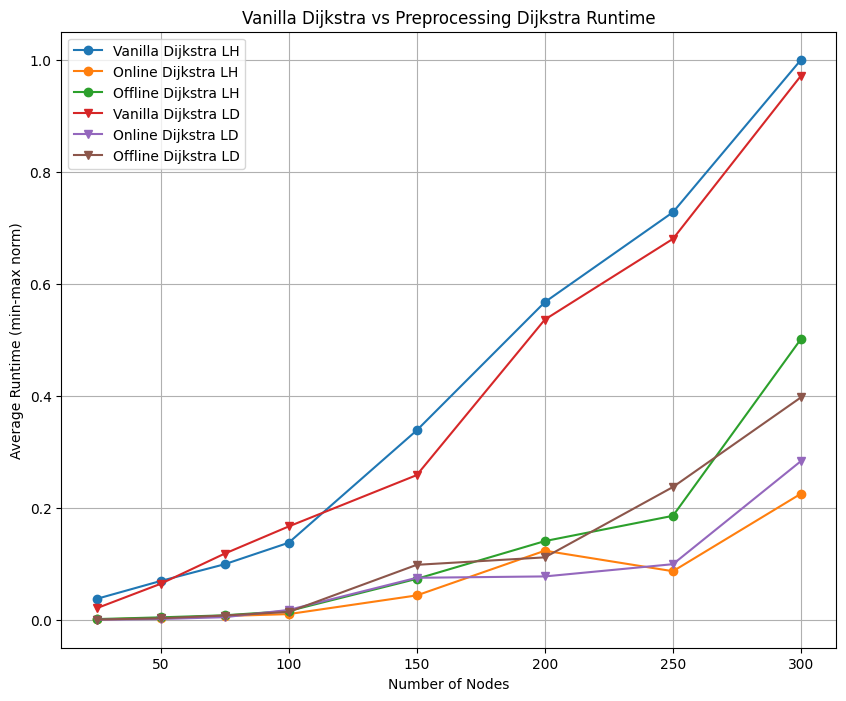

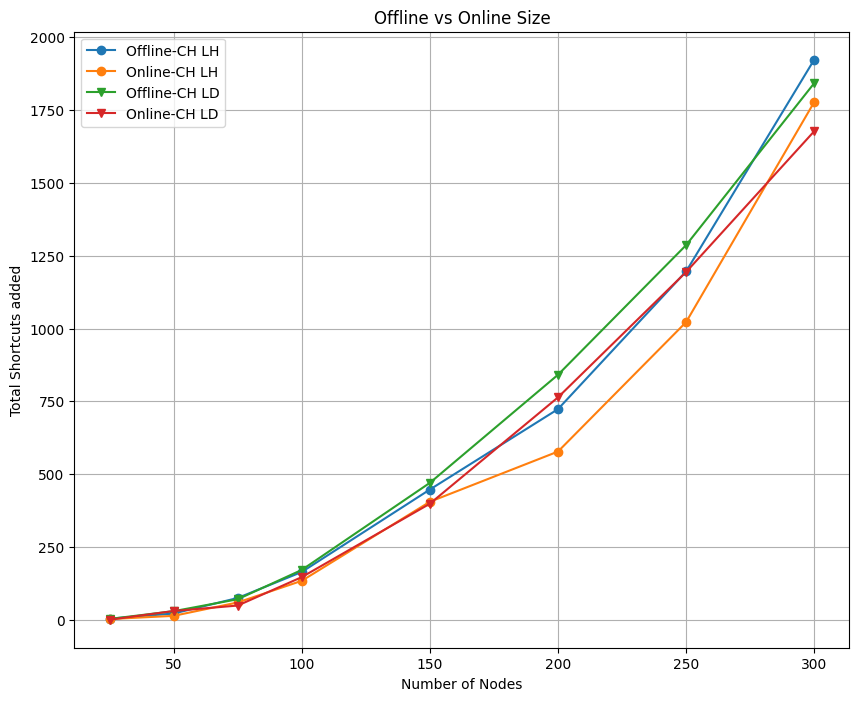

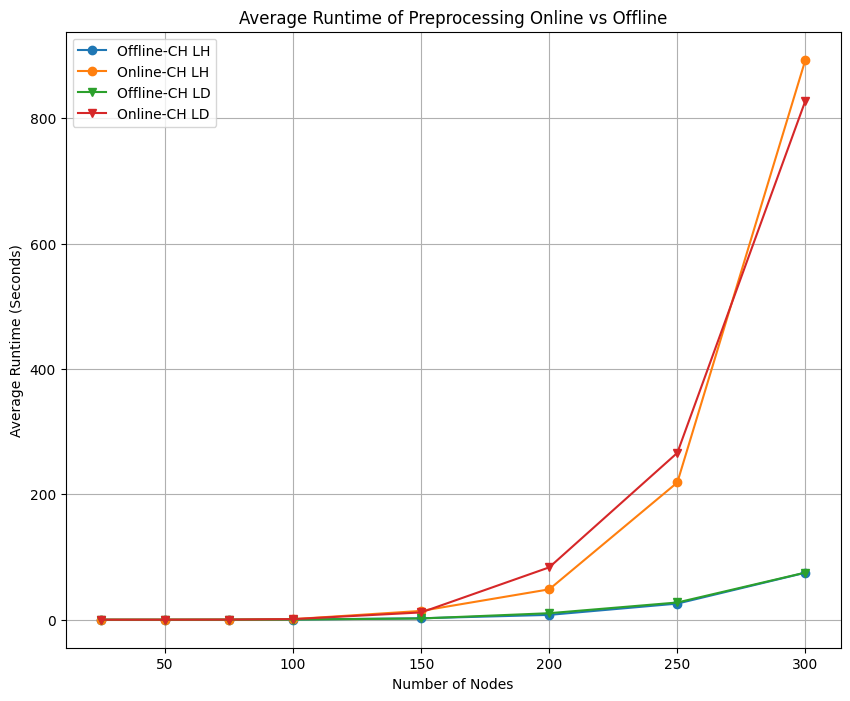

In [23]:
plotRuntimeAndMemory(sample_dict_lo_hi_lo_doub, sample_dict_lo_doub)